# Heart Disease Project

## Importing Dataset from local file.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

df_data = pd.read_csv("./data/heart.csv")

c:\Users\cgart\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\cgart\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


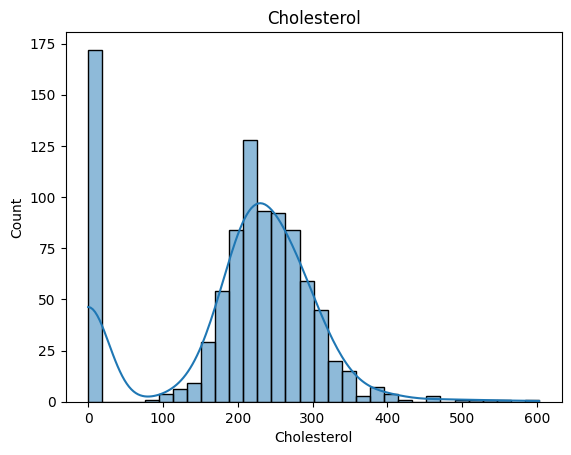

In [2]:
sns.histplot(df_data['Cholesterol'], kde=True)
plt.title("Cholesterol")
plt.show()

Below we need to impute data for the cholesterol as a very large proportion of the entries were 0 and so they have been replaced with the mean.  This just uses a simple imputer, but a KNearestNeighbors algorithm could maybe improve performance of the model later on.

As seen in the second graph the mean value is much higher now, but should prove more useful then keeping nearing 180 values as 0.

In [3]:
from sklearn.impute import SimpleImputer

si = SimpleImputer(missing_values=0, strategy='mean')

df_data['Cholesterol'] = si.fit_transform(df_data[['Cholesterol']])

c:\Users\cgart\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\cgart\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


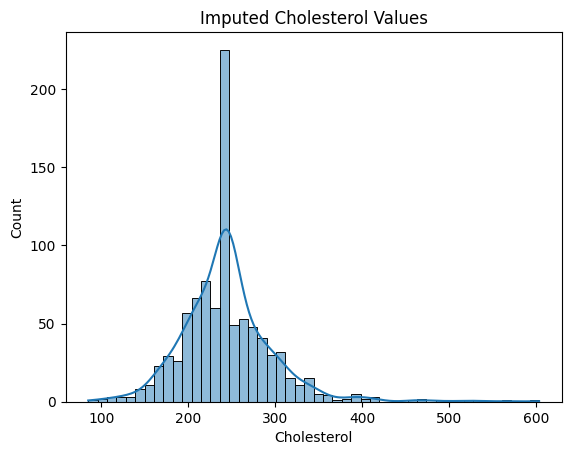

In [4]:
sns.histplot(df_data['Cholesterol'], kde=True)
plt.title("Imputed Cholesterol Values")
plt.show()

## Correlation Map
The graph below shows the correlation of values with each other.  This tells us that for the majority of values, there is little to no correlation amongst really any features.  Heart Disease does show some correlation with Max Heart Rate which is somewhat to be expected as a lower than average heart rate could be a sign of heart disease.

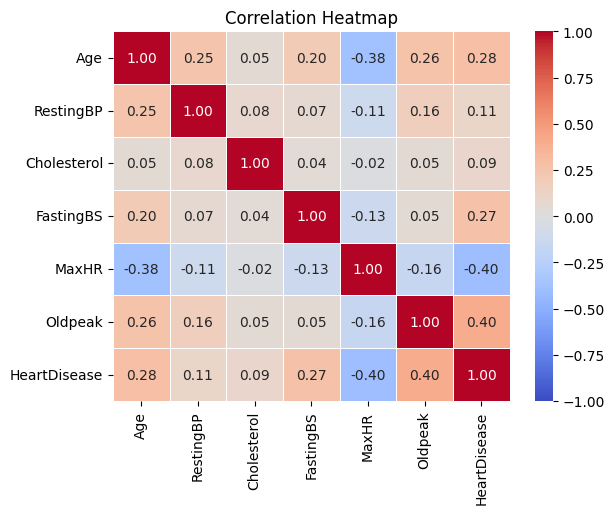

In [5]:
corr_matrix = df_data[['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

## Train Test Split
25% will be used in the testing dataset, and will be stratified so that the testing set has roughly the same amount of Heart Disease and Not Heart Disease characteristics.  We will also apply Standard Scalar and One Hot encoding to features that need it.

In [6]:
from sklearn.model_selection import train_test_split

X, y = df_data.drop(axis=1, columns=['HeartDisease']), df_data['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


ct = ColumnTransformer(
    [
        ('ss', StandardScaler(), ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']),
        ('onehot', OneHotEncoder(drop='first'), ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'])
    ],
    remainder='passthrough'
)


X_train_ct = ct.fit_transform(X_train)
X_test_ct = ct.transform(X_test)

columnNamesCT = ct.get_feature_names_out()

# Turn back into DataFrames
columns_to_drop = ['onehot__ChestPainType_NAP', 'onehot__RestingECG_Normal', 'onehot__ChestPainType_TA',
                   'onehot__RestingECG_ST', 'onehot__ChestPainType_ATA', 'remainder__FastingBS'] # Gathered from Random Forest Importance
X_train_ct_df = pd.DataFrame(X_train_ct, columns=columnNamesCT).drop(columns=columns_to_drop)
X_test_ct_df = pd.DataFrame(X_test_ct, columns=columnNamesCT).drop(columns=columns_to_drop)

## Model Selection

### Linear SVC
A good start for predicting Heart Disease with the given dataset would be to use a LinearSVC model.  We will use a GridSearchCV to make sure that we have optimized parameters and see how it performs using the ROC-AUC metric.

In [8]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

params = {
    'C': [0.0001*10**i for i in range(1, 10)],
    'tol': [0.000000000001*10**i for i in range(1, 10)]
}

clf_linear = LinearSVC(
    random_state=0,
    max_iter=10000,
    dual='auto'
)

gs_lin_clf = GridSearchCV(
    estimator=clf_linear,
    param_grid=params,
    scoring='accuracy',
    n_jobs=-1,
    refit=True,
    cv=10
)

gs_lin_clf.fit(X_train_ct_df, y_train)

print(gs_lin_clf.best_params_)

{'C': 1.0, 'tol': 1e-11}


Accuracy train/test: (0.85/0.83)


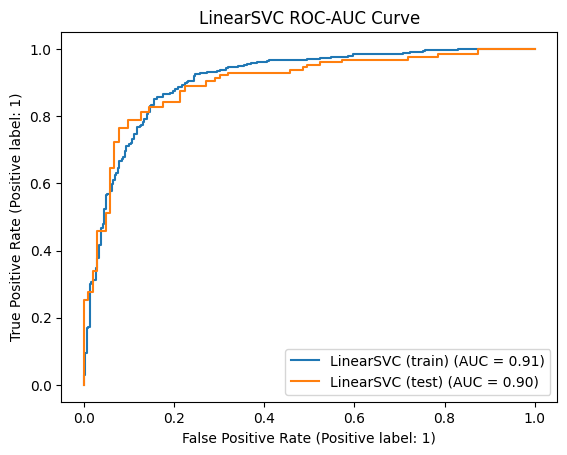

In [9]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score

train_acc = accuracy_score(y_train, gs_lin_clf.predict(X_train_ct_df))
test_acc = accuracy_score(y_test, gs_lin_clf.predict(X_test_ct_df))

print("Accuracy train/test: (%.2f/%.2f)" % (train_acc, test_acc))

lin_disp_train = RocCurveDisplay.from_estimator(gs_lin_clf, X_train_ct_df, y_train, name='LinearSVC (train)', ax=plt.gca())
lin_disp_test = RocCurveDisplay.from_estimator(gs_lin_clf, X_test_ct_df, y_test, name='LinearSVC (test)', ax=plt.gca())
plt.title("LinearSVC ROC-AUC Curve")
plt.show()


### KNearestNeighbors
While LinearSVC had good success, it will still be worth looking at other classifiers.

In [10]:
from sklearn.neighbors import KNeighborsClassifier

params = {
    'n_neighbors': [1+5*i for i in range(1, 10)],
    'leaf_size': [5+5*i for i in range(1, 10)]
}

clf_knn = KNeighborsClassifier(
    n_jobs=-1
)

gs_knn_clf = GridSearchCV(
    estimator=clf_knn,
    param_grid=params,
    scoring='accuracy',
    n_jobs=-1,
    refit=True,
    cv=10
)

gs_knn_clf.fit(X_train_ct_df, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'leaf_size': [10, 15, 20, 25, 30, 35, 40, 45, 50],
                         'n_neighbors': [6, 11, 16, 21, 26, 31, 36, 41, 46]},
             scoring='accuracy')

c:\Users\cgart\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\cgart\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


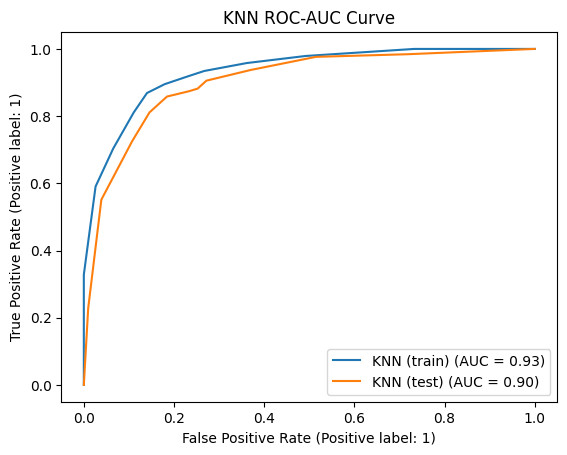

In [11]:
knn_disp_train = RocCurveDisplay.from_estimator(gs_knn_clf, X_train_ct_df.to_numpy(), y_train, name='KNN (train)', ax=plt.gca())
knn_disp_test = RocCurveDisplay.from_estimator(gs_knn_clf, X_test_ct_df.to_numpy(), y_test, name='KNN (test)', ax=plt.gca())
plt.title("KNN ROC-AUC Curve")
plt.show()

### Random Forest for Feature Importance

Random forests can provide insights on features that might be more important than others and could possibly do better than LinearSVC.

In [12]:
from sklearn.ensemble import RandomForestClassifier

params = {
    'n_estimators': [5*i for i in range(1, 10)],
    'criterion': ['gini', 'entropy'],
    'max_depth': [i for i in range(1, 10)]
}

clf_rfc = RandomForestClassifier(
    random_state=0,
    n_jobs=-1
)

gs_rfc_clf = GridSearchCV(
    estimator=clf_rfc,
    param_grid=params,
    cv=10,
    scoring='accuracy',
    refit=True,
    n_jobs=-1
)

gs_rfc_clf.fit(X_train_ct_df, y_train)

print(gs_rfc_clf.best_params_)

{'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 35}


c:\Users\cgart\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\cgart\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


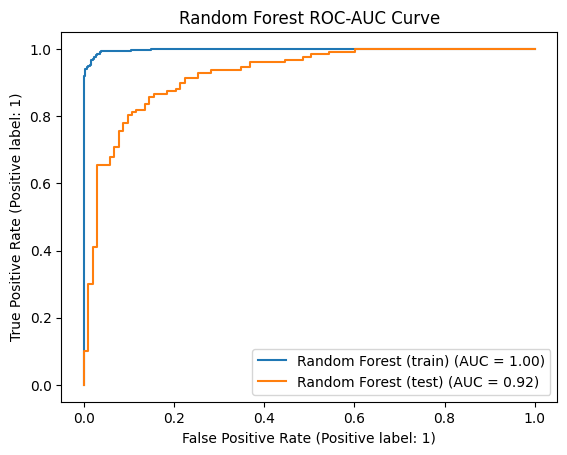

In [13]:
tree_disp_train = RocCurveDisplay.from_estimator(gs_rfc_clf, X_train_ct_df.to_numpy(), y_train, name='Random Forest (train)', ax=plt.gca())
tree_disp_test = RocCurveDisplay.from_estimator(gs_rfc_clf, X_test_ct_df.to_numpy(), y_test, name='Random Forest (test)', ax=plt.gca())
plt.title("Random Forest ROC-AUC Curve")
plt.show()

[]

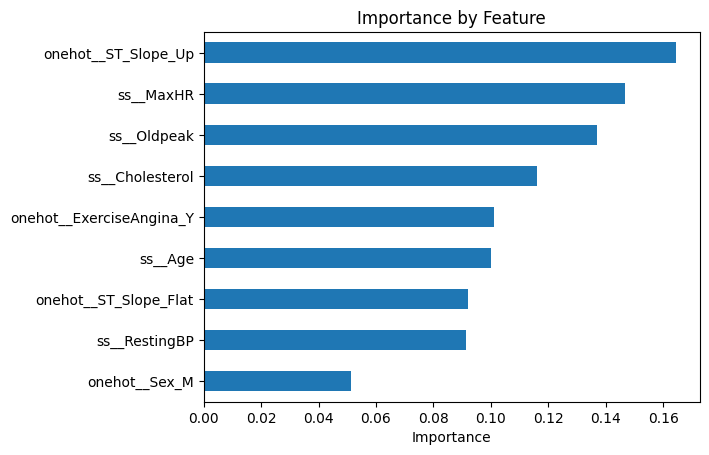

In [14]:
importance = pd.Series(gs_rfc_clf.best_estimator_.feature_importances_, index=gs_rfc_clf.best_estimator_.feature_names_in_)

importance = importance.sort_values(ascending=True)

importance.plot(kind='barh')
plt.title("Importance by Feature")
plt.xlabel("Importance")
plt.plot()

As seen in the graph, ST_Slope_Up is a very good predictor for heart disease and as such is very important.  It should be noted that ChestPainType_NAP, FastingBS, RestingECG_Normal, ChestPainType_TA, ChestpainType_ATA and RestingECG_ST were removed after an iterative process as they had less than 2.5% importance in determining heart disease.

### Voting

We might be able to get more accurate by implementing a voting system between KNN and LinearSVC.

In [15]:
from sklearn.ensemble import VotingClassifier

clf_vc = VotingClassifier(
    estimators=[
        ("LinearSVC", gs_lin_clf),
        ("KNN", gs_knn_clf),
        ("Random Forest", gs_rfc_clf)
    ]
)

clf_vc.fit(X_train_ct_df, y_train)

VotingClassifier(estimators=[('LinearSVC',
                              GridSearchCV(cv=10,
                                           estimator=LinearSVC(dual='auto',
                                                               max_iter=10000,
                                                               random_state=0),
                                           n_jobs=-1,
                                           param_grid={'C': [0.001, 0.01, 0.1,
                                                             1.0, 10.0, 100.0,
                                                             1000.0, 10000.0,
                                                             100000.0],
                                                       'tol': [1e-11, 1e-10,
                                                               1e-09, 1e-08,
                                                               1e-07, 1e-06,
                                                               9.999999999999999e-06,
                                                               9.999999999999999e-05,
                                                               0.001]},
                                           scoring='accuracy')),
                             ('KNN',
                              GridSearchCV(cv=10,
                                           es...
                                           param_grid={'leaf_size': [10, 15, 20,
                                                                     25, 30, 35,
                                                                     40, 45,
                                                                     50],
                                                       'n_neighbors': [6, 11,
                                                                       16, 21,
                                                                       26, 31,
                                                                       36, 41,
                                                                       46]},
                                           scoring='accuracy')),
                             ('Random Forest',
                              GridSearchCV(cv=10,
                                           estimator=RandomForestClassifier(n_jobs=-1,
                                                                            random_state=0),
                                           n_jobs=-1,
                                           param_grid={'criterion': ['gini',
                                                                     'entropy'],
                                                       'max_depth': [1, 2, 3, 4,
                                                                     5, 6, 7, 8,
                                                                     9],
                                                       'n_estimators': [5, 10,
                                                                        15, 20,
                                                                        25, 30,
                                                                        35, 40,
                                                                        45]},
                                           scoring='accuracy'))])

c:\Users\cgart\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\cgart\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


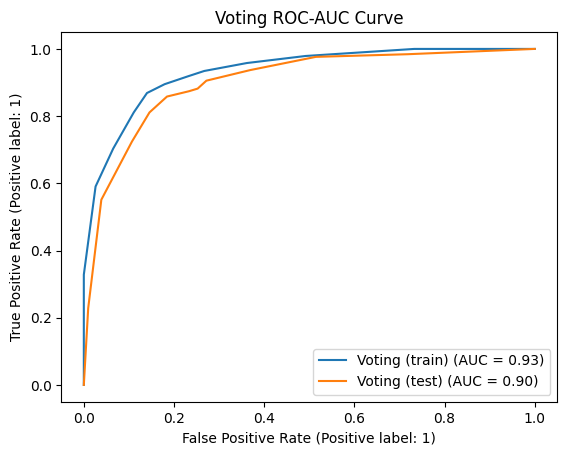

In [16]:
vote_disp_train = RocCurveDisplay.from_estimator(gs_knn_clf, X_train_ct_df.to_numpy(), y_train, name='Voting (train)', ax=plt.gca())
vote_disp_test = RocCurveDisplay.from_estimator(gs_knn_clf, X_test_ct_df.to_numpy(), y_test, name='Voting (test)', ax=plt.gca())
plt.title("Voting ROC-AUC Curve")
plt.show()

## ROC-AUC Curve Comparissons

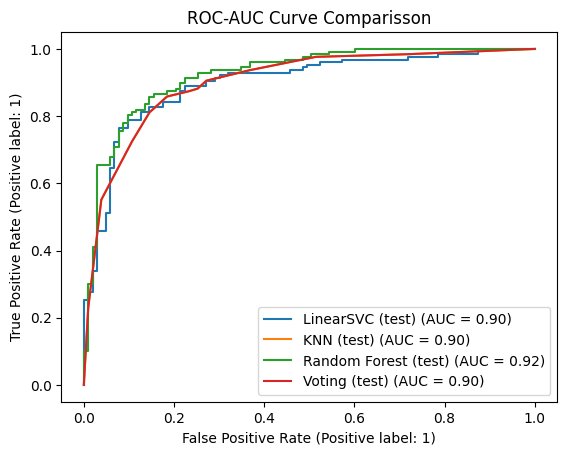

In [17]:
lin_disp_test.plot(ax=plt.gca())
knn_disp_test.plot(ax=plt.gca())
tree_disp_test.plot(ax=plt.gca())
vote_disp_test.plot(ax=plt.gca())
plt.title("ROC-AUC Curve Comparisson")
plt.show()

In [19]:
# Accuracy scores on each model with training dataset

from sklearn.model_selection import cross_val_score

scores_lin = cross_val_score(gs_lin_clf, X_train_ct_df, y_train, cv=3)
scores_knn = cross_val_score(gs_knn_clf, X_train_ct_df, y_train, cv=3)
scores_vote = cross_val_score(clf_vc, X_train_ct_df, y_train, cv=3)
scores_forest = cross_val_score(gs_rfc_clf, X_train_ct_df, y_train, cv=3)
print("LinearSVC: %.3f(+- %.3f)" % (scores_lin.mean(), scores_lin.std()))
print("KNN: %.3f(+- %.3f)" % (scores_knn.mean(), scores_knn.std()))
print("Voting: %.3f(+- %.3f)" % (scores_vote.mean(), scores_vote.std()))
print("Random Forest: %.3f(+- %.3f)" % (scores_forest.mean(), scores_forest.std()))

LinearSVC: 0.837(+- 0.011)
KNN: 0.842(+- 0.015)
Voting: 0.847(+- 0.010)
Random Forest: 0.827(+- 0.005)


In [20]:
print("Voting (test): %.3f" % (clf_vc.score(X_test_ct_df, y_test)))

Voting (test): 0.826


### Conclusion

Each method is good on its own, but Voting amongst the 3 other classifiers did prove to increase the accuracy a bit, and decrease the variance by a good amount.  This resulted in a Voting Classifier that when tested on the testing set had about 82.6% accuracy.  There are many ways that this could have been improved like adding in Principle Component Analysis could help with feature selection and aiding the training of models.  Another thing that could improve accuracy is using different ensemble methods like bagging or boosting.

One thing that is important to point out is the ROC-AUC scores of the models
